# FinRisk: Credit Risk & Fraud Detection - Notebook 3
## Phase 2: Credit Risk Modeling & Validation

**Objective:**
1.  Load the processed feature-engineered dataset.
2.  Prepare the data for modeling (encoding, scaling).
3.  Split the data into training and testing sets using a time-based strategy.
4.  Train three models: Logistic Regression (baseline), Random Forest, and XGBoost.
5.  Evaluate model performance using AUC, Gini, and Kolmogorov-Smirnov (KS) statistics.
6.  Interpret the best model's predictions using SHAP.

In [1]:
# ==============================================================================
# 1. Import Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Settings
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

print("Libraries imported successfully.")
print(f"SHAP version: {shap.__version__}")

# Configure settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

c:\Users\kenny\Documents\Data Science project folders\finrisk\FinRisk-ai-internship\kehinde-finrisk\fin_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully.
SHAP version: 0.48.0


## 2. Load Processed Data

We'll load the `credit_risk_features.csv` file from the `../data/processed/` directory.

In [2]:
PROCESSED_DATA_PATH = '../data/processed/'
DATA_FILE = 'credit_risk_features.csv'

try:
    df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, DATA_FILE), parse_dates=['application_date'])
    print("Processed data loaded successfully.")
    print(f"Data shape: {df.shape}")
    print(df.head())
except FileNotFoundError:
    print(f"Error: {DATA_FILE} not found. Please run the previous notebook first.")
    assert False, "Data file not found."

Processed data loaded successfully.
Data shape: (96766, 29)
  application_id  customer_id application_date  loan_amount   loan_purpose  \
0    APP_0000001  CUST_008172       2023-09-03       164883  Home Purchase   
1    APP_0000002  CUST_016851       2023-05-02        59782  Home Purchase   
2    APP_0000003  CUST_016766       2024-08-08        23716   Car Purchase   
3    APP_0000004  CUST_018679       2024-07-22        13514   Car Purchase   
4    APP_0000005  CUST_019411       2024-08-13        13992   Car Purchase   

   debt_to_income_ratio application_status  default_flag  customer_age  \
0                 0.828           Declined             0            81   
1                 1.005           Declined             0            34   
2                 0.694           Declined             0            18   
3                 0.710           Declined             0            18   
4                 0.530           Declined             0            18   

   annual_income_profile e

## 3. Data Preparation for Modeling

We will define our feature set (`X`) and target variable (`y`). Then, we'll create a preprocessing pipeline to handle categorical and numerical features appropriately.

In [3]:
df.head()

,application_id,customer_id,application_date,loan_amount,loan_purpose,debt_to_income_ratio,application_status,default_flag,customer_age,annual_income_profile,employment_status_profile,account_tenure,product_holdings,relationship_value,risk_segment,behavioral_score,city,last_activity_date,credit_score,credit_history_length,number_of_accounts,total_credit_limit,credit_utilization,payment_history,public_records,loan_to_income_ratio,days_since_last_activity,credit_history_years,credit_score_x_dti
0,APP_0000001,CUST_008172,2023-09-03,164883,Home Purchase,0.828,Declined,0,81,85399.18,Retired,1,3,28181.73,Near-Prime,150.71,London,2025-07-13,675,14,5,22286,0.633,0.865,0,1.930733,-195,1.166667,558.900
1,APP_0000002,CUST_016851,2023-05-02,59782,Home Purchase,1.005,Declined,0,34,20582.50,Full-time,2,3,7409.70,Near-Prime,440.25,Glasgow,2025-08-03,677,3,2,13976,0.611,0.884,0,2.904506,-216,0.250000,680.385
2,APP_0000003,CUST_016766,2024-08-08,23716,Car Purchase,0.694,Declined,0,18,11860.21,Part-time,1,2,2609.25,Near-Prime,328.65,London,2025-07-27,732,0,2,1695,0.480,0.888,0,1.999627,-209,0.000000,508.008
3,APP_0000004,CUST_018679,2024-07-22,13514,Car Purchase,0.710,Declined,0,18,16490.54,Part-time,7,3,8410.18,Prime,207.90,London,2025-08-05,850,0,6,1530,0.021,0.995,0,0.819500,-218,0.000000,603.500
4,APP_0000005,CUST_019411,2024-08-13,13992,Car Purchase,0.530,Declined,0,18,9600.00,Part-time,4,1,1344.00,Subprime,478.07,London,2025-07-27,630,0,6,7076,0.643,0.809,0,1.457500,-209,0.000000,333.900


In [4]:
df.columns

Index(['application_id', 'customer_id', 'application_date', 'loan_amount',
       'loan_purpose', 'debt_to_income_ratio', 'application_status',
       'default_flag', 'customer_age', 'annual_income_profile',
       'employment_status_profile', 'account_tenure', 'product_holdings',
       'relationship_value', 'risk_segment', 'behavioral_score', 'city',
       'last_activity_date', 'credit_score', 'credit_history_length',
       'number_of_accounts', 'total_credit_limit', 'credit_utilization',
       'payment_history', 'public_records', 'loan_to_income_ratio',
       'days_since_last_activity', 'credit_history_years',
       'credit_score_x_dti'],
      dtype='object')

In [5]:
# Define target and features
TARGET = 'default_flag'
# Exclude identifiers, dates, and the target itself from the feature list
features_to_exclude = [
    'application_id', 'customer_id', 'application_date', 'last_activity_date',
    'default_flag', 'application_status', 'city'
]
X = df.drop(columns=features_to_exclude)
y = df[TARGET]

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=np.number).columns

print(f"Target variable: {TARGET}")
print(f"Number of features: {X.shape[1]}")
print(f"Numerical features: {list(numerical_features)}")
print(f"Categorical features: {list(categorical_features)}")

# Create a preprocessing pipeline
# OneHotEncoder handles categorical variables, StandardScaler scales numerical ones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any
)

Target variable: default_flag
Number of features: 22
Numerical features: ['loan_amount', 'debt_to_income_ratio', 'customer_age', 'annual_income_profile', 'account_tenure', 'product_holdings', 'relationship_value', 'behavioral_score', 'credit_score', 'credit_history_length', 'number_of_accounts', 'total_credit_limit', 'credit_utilization', 'payment_history', 'public_records', 'loan_to_income_ratio', 'days_since_last_activity', 'credit_history_years', 'credit_score_x_dti']
Categorical features: ['loan_purpose', 'employment_status_profile', 'risk_segment']


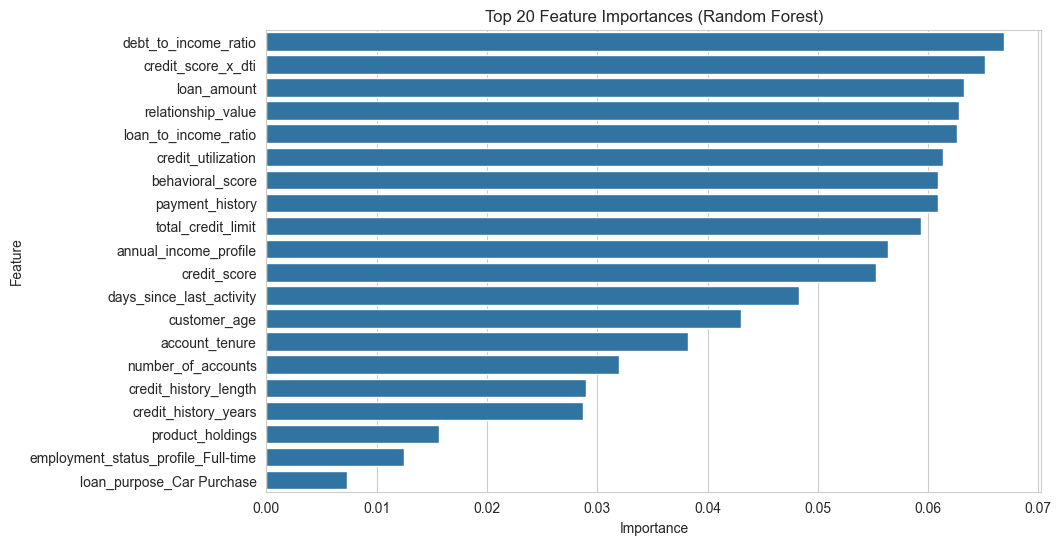

In [6]:
# ...existing code...

# Transform features using the pipeline
X_transformed = preprocessor.fit_transform(X)

# Random Forest for feature importance
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_transformed, y)

# Get feature names after transformation
feature_names = []
feature_names.extend(numerical_features)
feature_names.extend(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Top 20 features by importance
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

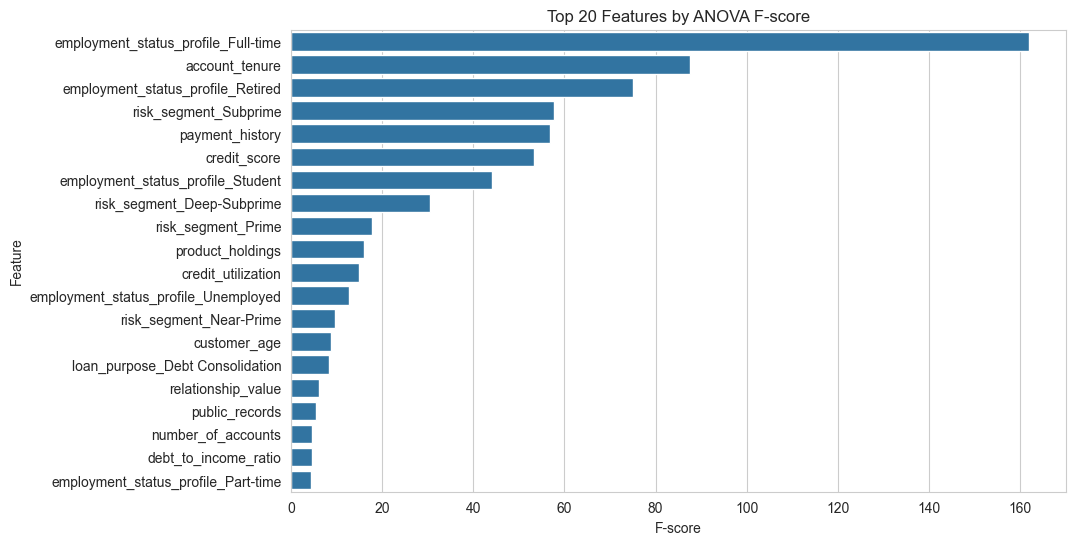

In [7]:
# SelectKBest for univariate feature selection
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=20)
selector.fit(X_transformed, y)

selected_features = np.array(feature_names)[selector.get_support()]
scores = selector.scores_[selector.get_support()]

feat_scores = pd.Series(scores, index=selected_features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_scores.values, y=feat_scores.index)
plt.title('Top 20 Features by ANOVA F-score')
plt.xlabel('F-score')
plt.ylabel('Feature')
plt.show()
# ...existing code...

## 4. Time-Based Train-Test Split

For financial data, a random split is not appropriate as it can lead to data leakage (using future information to train the model). We will sort the data by `application_date` and use the oldest 80% for training and the most recent 20% for out-of-time validation.

In [8]:
# Sort dataframe by date
df_sorted = df.sort_values('application_date')

# Define split point
split_index = int(len(df_sorted) * 0.8)

# Split the data
train_df = df_sorted.iloc[:split_index]
test_df = df_sorted.iloc[split_index:]

# Create X and y for train and test sets
X_train = train_df[X.columns]
y_train = train_df[TARGET]
X_test = test_df[X.columns]
y_test = test_df[TARGET]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training period: {train_df['application_date'].min()} to {train_df['application_date'].max()}")
print(f"Testing period: {test_df['application_date'].min()} to {test_df['application_date'].max()}")

Training data shape: (77412, 22)
Testing data shape: (19354, 22)
Training period: 2022-01-01 00:00:00 to 2024-05-28 00:00:00
Testing period: 2024-05-28 00:00:00 to 2024-12-30 00:00:00


## 5. Model Training

We will define our three candidate models and train them within a scikit-learn pipeline, which handles the preprocessing automatically.

In [9]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Train models and store results
results = {}
trained_pipelines = {}

for name, model in models.items():
    print(f"--- Training {name} ---")
    
    # Create the full pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Store the trained pipeline
    trained_pipelines[name] = pipeline
    
    # Make predictions on the test set (probabilities)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Store probabilities for evaluation
    results[name] = {
        'y_pred_proba': y_pred_proba
    }
    print(f"{name} trained successfully.")

--- Training Logistic Regression ---
Logistic Regression trained successfully.
--- Training Random Forest ---
Random Forest trained successfully.
--- Training XGBoost ---
XGBoost trained successfully.


## 6. Model Evaluation

We'll evaluate the models using AUC, Gini, and the KS statistic. The KS statistic is particularly important in credit risk as it measures a model's ability to separate good and bad customers.

--- Model Performance Summary ---
                 Model       AUC      Gini  KS Statistic
0  Logistic Regression  0.645399  0.290798      0.233585
1        Random Forest  0.562223  0.124445      0.114360
2              XGBoost  0.585229  0.170459      0.149625


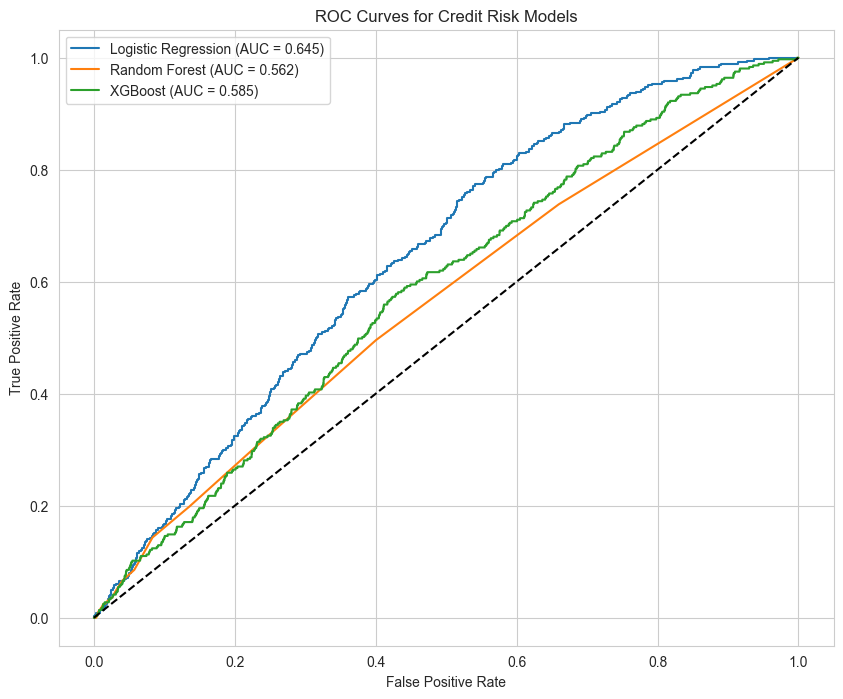

In [10]:
def calculate_ks_and_gini(y_true, y_pred_proba):
    """Calculates the KS statistic and Gini coefficient."""
    # Gini calculation
    auc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc - 1
    
    # KS Statistic calculation
    data = pd.DataFrame({'y_true': y_true, 'y_pred_proba': y_pred_proba})
    data = data.sort_values(by='y_pred_proba', ascending=False)
    
    data['cumulative_good'] = (1 - data['y_true']).cumsum() / (1 - data['y_true']).sum()
    data['cumulative_bad'] = data['y_true'].cumsum() / data['y_true'].sum()
    
    ks_statistic = np.max(np.abs(data['cumulative_bad'] - data['cumulative_good']))
    
    return ks_statistic, gini

# Calculate and store metrics
evaluation_summary = []
plt.figure(figsize=(10, 8))

for name, res in results.items():
    y_pred_proba = res['y_pred_proba']
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_pred_proba)
    ks, gini = calculate_ks_and_gini(y_test, y_pred_proba)
    
    results[name]['auc'] = auc
    results[name]['ks'] = ks
    results[name]['gini'] = gini
    
    evaluation_summary.append({'Model': name, 'AUC': auc, 'Gini': gini, 'KS Statistic': ks})
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

# Display results
evaluation_df = pd.DataFrame(evaluation_summary)
print("--- Model Performance Summary ---")
print(evaluation_df)

# Finalize plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Credit Risk Models')
plt.legend()
plt.show()

## 7. Model Interpretation with SHAP

Based on the results, XGBoost is likely the best-performing model. Let's use SHAP (SHapley Additive exPlanations) to understand its predictions. This is crucial for regulatory compliance and building trust with stakeholders.

--- SHAP Analysis: Global Feature Importance ---


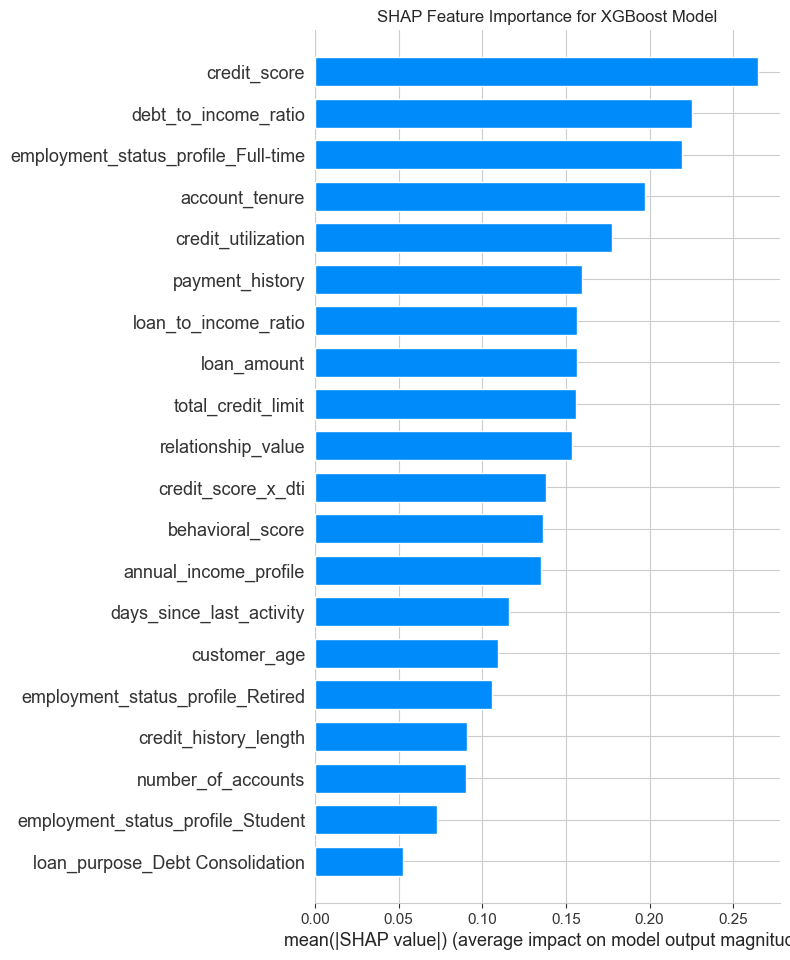

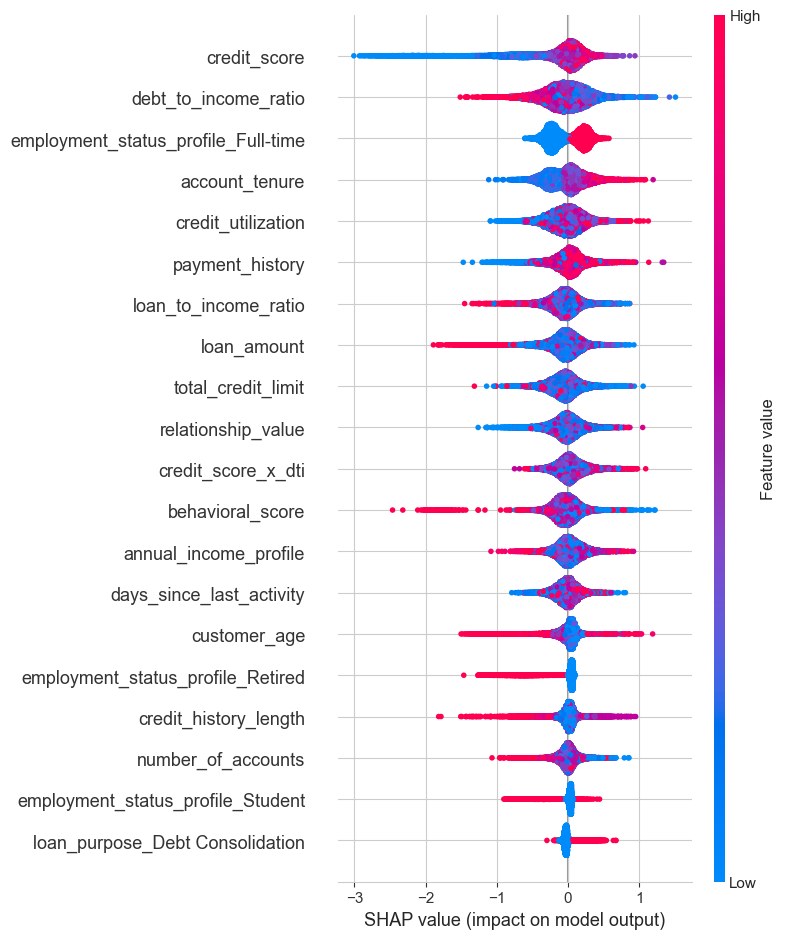


--- SHAP Analysis: Explaining a Single Prediction ---


In [11]:
# Select the best model (XGBoost)
best_model_name = 'XGBoost'
best_pipeline = trained_pipelines[best_model_name]

# SHAP requires the data to be transformed first
# We get the transformed data from the pipeline's preprocessor step
X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)
# Get feature names after one-hot encoding
feature_names = numerical_features.tolist() + \
                best_pipeline.named_steps['preprocessor'].named_transformers_['cat']\
                .get_feature_names_out(categorical_features).tolist()

# Convert to a dense array if it's sparse
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed_dense = X_test_transformed.toarray()
else:
    X_test_transformed_dense = X_test_transformed

# Create a SHAP explainer
explainer = shap.TreeExplainer(best_pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(X_test_transformed_dense)

# Create a DataFrame for easier use
X_test_transformed_df = pd.DataFrame(X_test_transformed_dense, columns=feature_names)

print("--- SHAP Analysis: Global Feature Importance ---")
# Summary Plot (Beeswarm)
shap.summary_plot(shap_values, X_test_transformed_df, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for XGBoost Model")
plt.show()

shap.summary_plot(shap_values, X_test_transformed_df)

print("\n--- SHAP Analysis: Explaining a Single Prediction ---")
# Explain a single prediction (e.g., the first instance in the test set)
shap.initjs()
# We use a force plot to see the factors pushing the prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_transformed_df.iloc[0,:])

# FinRisk: Credit Risk & Fraud Detection - Notebook 4
## Phase 2: Optimized Credit Risk Modeling & Validation

**Objective:** To significantly improve model performance by addressing the severe class imbalance in the `default_flag` target variable. We will implement and compare cost-sensitive learning and SMOTE oversampling to meet the project's success metrics (AUC > 0.75, KS > 40).

In [12]:
# ==============================================================================
# 1. Import Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Scikit-learn and imbalanced-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as ImbPipeline # Use pipeline from imblearn
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Settings
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Load Data and Re-run Preparation Steps

We will load the same processed data and repeat the initial preparation to ensure this notebook is self-contained.

In [13]:
# Load data
PROCESSED_DATA_PATH = '../data/processed/'
DATA_FILE = 'credit_risk_features.csv'
df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, DATA_FILE), parse_dates=['application_date'])

# Define features (X) and target (y)
TARGET = 'default_flag'
features_to_exclude = [
    'application_id', 'customer_id', 'application_date', 'last_activity_date',
    'default_flag', 'application_status', 'city'
]
X = df.drop(columns=features_to_exclude)
y = df[TARGET]

# Identify feature types
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Time-based split
df_sorted = df.sort_values('application_date')
split_index = int(len(df_sorted) * 0.8)
train_df, test_df = df_sorted.iloc[:split_index], df_sorted.iloc[split_index:]
X_train, y_train = train_df[X.columns], train_df[TARGET]
X_test, y_test = test_df[X.columns], test_df[TARGET]

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

Training data shape: (77412, 22), Testing data shape: (19354, 22)


## 3. Analyze Class Imbalance

Let's explicitly calculate the imbalance ratio. This will inform our strategy. The `scale_pos_weight` for XGBoost is typically set to `count(negative_class) / count(positive_class)`.

In [14]:
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Class distribution in training data:\n{y_train.value_counts()}")
print(f"\nImbalance Ratio (0s to 1s): {imbalance_ratio:.2f}")

# This ratio is the value we'll use for scale_pos_weight in XGBoost
SCALE_POS_WEIGHT = imbalance_ratio

Class distribution in training data:
default_flag
0    75887
1     1525
Name: count, dtype: int64

Imbalance Ratio (0s to 1s): 49.76


## 4. Modeling Strategy 1: Cost-Sensitive Learning

We will configure our models to penalize errors on the minority class more heavily. This forces the model to pay more attention to the rare "default" cases.

In [15]:
# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Define models with cost-sensitive parameters
models_cost_sensitive = {
    "Logistic Regression (Balanced)": LogisticRegression(
        random_state=42, class_weight='balanced', solver='liblinear'
    ),
    "XGBoost (Cost-Sensitive)": xgb.XGBClassifier(
        random_state=42, use_label_encoder=False, eval_metric='logloss',
        # This is the key parameter for handling imbalance
        scale_pos_weight=SCALE_POS_WEIGHT,
        # Starting with some tuned parameters
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1
    )
}

# Train and evaluate
results = {}
trained_pipelines = {}

print("--- Training Cost-Sensitive Models ---")
for name, model in models_cost_sensitive.items():
    pipeline = ImbPipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipeline.fit(X_train, y_train)
    trained_pipelines[name] = pipeline
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    results[name] = {'y_pred_proba': y_pred_proba}
    print(f"{name} trained.")

--- Training Cost-Sensitive Models ---
Logistic Regression (Balanced) trained.
XGBoost (Cost-Sensitive) trained.


## 5. Modeling Strategy 2: SMOTE Oversampling

Here, we will integrate SMOTE directly into our training pipeline. It's crucial that SMOTE is **only applied to the training data**, never to the test data. The `imbalanced-learn` pipeline makes this easy and safe.

In [16]:
# Define models for the SMOTE pipeline
# We don't need cost-sensitive parameters here as SMOTE handles the balance
models_smote = {
    "XGBoost (SMOTE)": xgb.XGBClassifier(
        random_state=42, use_label_encoder=False, eval_metric='logloss',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1
    )
}

print("\n--- Training Models with SMOTE ---")
for name, model in models_smote.items():
    # Create a pipeline with SMOTE, then the model
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)), # SMOTE step
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    trained_pipelines[name] = pipeline
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    results[name] = {'y_pred_proba': y_pred_proba}
    print(f"{name} trained.")


--- Training Models with SMOTE ---
XGBoost (SMOTE) trained.


## 6. Final Evaluation and Comparison

Now we'll evaluate all our new models and see how they stack up against the project's success metrics.

--- Optimized Model Performance Summary ---
                            Model       AUC      Gini  KS Statistic
0  Logistic Regression (Balanced)  0.645377  0.290754     23.326955
2                 XGBoost (SMOTE)  0.598552  0.197104     15.342457
1        XGBoost (Cost-Sensitive)  0.585614  0.171227     13.557314

--- Checking Against Success Metrics ---
Best Model: Logistic Regression (Balanced)
AUC > 0.75: FAIL (Actual: 0.645)
KS > 40: FAIL (Actual: 23.33)
Gini > 0.50: FAIL (Actual: 0.291)


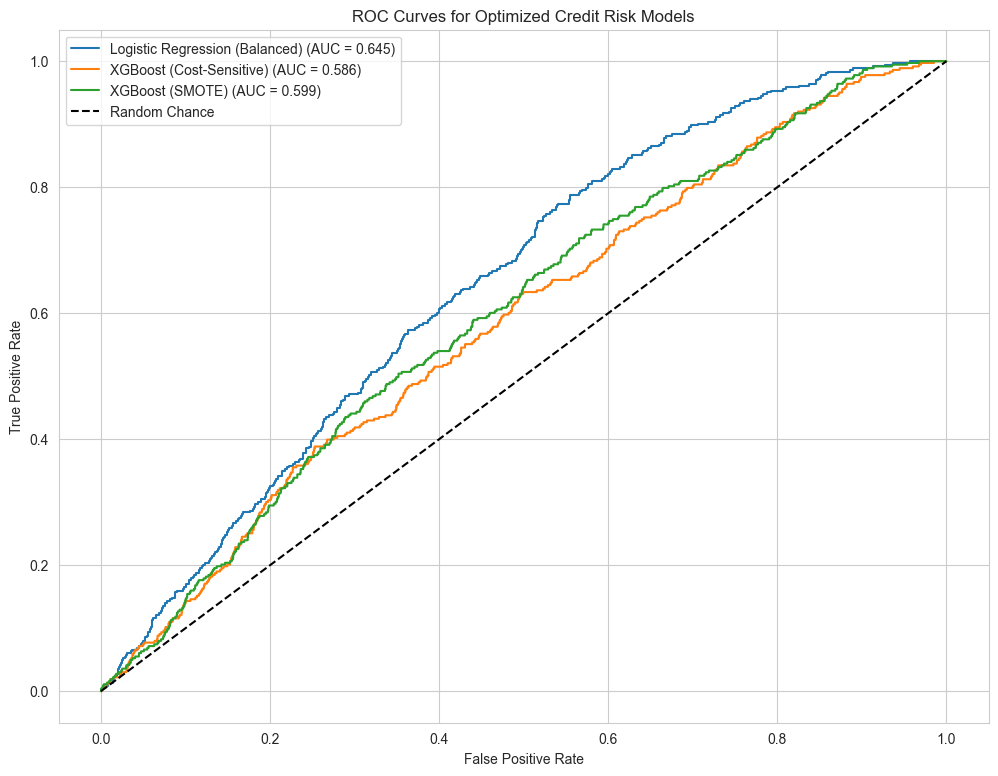

In [17]:
def calculate_ks_and_gini(y_true, y_pred_proba):
    """Calculates the KS statistic and Gini coefficient."""
    auc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc - 1
    
    data = pd.DataFrame({'y_true': y_true, 'y_pred_proba': y_pred_proba})
    data = data.sort_values(by='y_pred_proba', ascending=False)
    
    data['cumulative_good'] = (1 - data['y_true']).cumsum() / (1 - data['y_true']).sum()
    data['cumulative_bad'] = data['y_true'].cumsum() / data['y_true'].sum()
    
    ks_statistic = np.max(np.abs(data['cumulative_bad'] - data['cumulative_good']))
    
    return ks_statistic, gini

# Calculate and store metrics
evaluation_summary = []
plt.figure(figsize=(12, 9))

for name, res in results.items():
    auc = roc_auc_score(y_test, res['y_pred_proba'])
    ks, gini = calculate_ks_and_gini(y_test, res['y_pred_proba'])
    
    # Note: KS statistic is usually represented as a percentage (0-100)
    ks_percent = ks * 100
    
    evaluation_summary.append({'Model': name, 'AUC': auc, 'Gini': gini, 'KS Statistic': ks_percent})
    
    fpr, tpr, _ = roc_curve(y_test, res['y_pred_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

# Display results
evaluation_df = pd.DataFrame(evaluation_summary).sort_values(by='AUC', ascending=False)
print("--- Optimized Model Performance Summary ---")
print(evaluation_df)

# Check against success metrics
print("\n--- Checking Against Success Metrics ---")
best_model_stats = evaluation_df.iloc[0]
auc_check = "PASS" if best_model_stats['AUC'] > 0.75 else "FAIL"
ks_check = "PASS" if best_model_stats['KS Statistic'] > 40 else "FAIL"
gini_check = "PASS" if best_model_stats['Gini'] > 0.50 else "FAIL"

print(f"Best Model: {best_model_stats['Model']}")
print(f"AUC > 0.75: {auc_check} (Actual: {best_model_stats['AUC']:.3f})")
print(f"KS > 40: {ks_check} (Actual: {best_model_stats['KS Statistic']:.2f})")
print(f"Gini > 0.50: {gini_check} (Actual: {best_model_stats['Gini']:.3f})")

# Finalize plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Optimized Credit Risk Models')
plt.legend()
plt.show()